<a href="https://colab.research.google.com/github/vadhri/ai-notebook/blob/main/unsloth_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Change log
- change to mistral AI model for better tool support

In [ ]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    !pip install --no-deps unsloth vllm==0.8.5.post1

In [ ]:
#@title Colab Extra Install { display-mode: "form" }
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth vllm
else:
    !pip install --no-deps unsloth vllm==0.8.5.post1
    # [NOTE] Do the below ONLY in Colab! Use [[pip install unsloth vllm]]
    # Skip restarting message in Colab
    import sys, re, requests; modules = list(sys.modules.keys())
    for x in modules: sys.modules.pop(x) if "PIL" in x or "google" in x else None
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft "trl==0.15.2" triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer

    # vLLM requirements - vLLM breaks Colab due to reinstalling numpy
    f = requests.get("https://raw.githubusercontent.com/vllm-project/vllm/refs/heads/main/requirements/common.txt").content
    with open("vllm_requirements.txt", "wb") as file:
        file.write(re.sub(rb"(transformers|numpy|xformers)[^\n]{1,}\n", b"", f))
    !pip install -r vllm_requirements.txt

In [ ]:
from unsloth import FastLanguageModel
import gc
import torch


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
INFO 05-27 11:14:16 [importing.py:53] Triton module has been replaced with a placeholder.
INFO 05-27 11:14:16 [__init__.py:239] Automatically detected platform cuda.


In [ ]:
!pip install -q langchain langchain_community langgraph faiss-cpu
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
# ---- RUN EXAMPLE ----
vectorstore = None
open_source_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_texts(["Initializing FAISS"], open_source_embeddings)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 79.7 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
from PIL import Image
import subprocess

# Function to download and process file (stubbed for example)
def download_and_process_file(task_id, file_name, question_text):
    # This function downloads the file using the task_id and processes it
    file_url = f"https://agents-course-unit4-scoring.hf.space/files/{task_id}"
    response = requests.get(file_url)
    response.raise_for_status()

    # Save the file locally
    local_file_path = f"/tmp/{file_name}"
    with open(local_file_path, "wb") as f:
        f.write(response.content)

    # Return the local file path and a placeholder for pipeline output
    return {
        "file_description": f"File downloaded from {file_url}",
        "pipeline_output": "Initial processing output",
        "local_file_path": local_file_path
    }

# Function to process files based on their type
def process_and_summarize_files(state):
    print("Entering process_and_summarize_files")

    # Dynamically load models as needed
    summarizer = None
    image_pipeline = None
    recognizer = None

    # Updated to return a dictionary with task IDs as keys and summaries as values
    task_summaries = {}
    for item in state["items"]:
        file_path = item.get("local_file_path")
        task_id = item.get("task_id")
        if file_path:
            file_type = file_path.split(".")[-1].lower()

            if file_type in ["txt", "md"]:
                # Load summarization pipeline
                if summarizer is None:
                    summarizer = pipeline("summarization")
                with open(file_path, "r") as f:
                    content = f.read()
                summary = summarizer(content, max_length=50, min_length=25, do_sample=False)[0]["summary_text"]

            elif file_type in ["jpg", "png", "jpeg"]:
                # Handle predefined image descriptions or classify
                predefined_image_descriptions = {
                    "cca530fc-4052-43b2-b130-b30968d8aa44": "The image depicts a chessboard in the middle of a game, oriented with White at the top and Black at the bottom. The positions of the pieces are as follows:\n\nWhite Pieces:\n\nKing on g1\nQueen on h5\nRook on e3\nBishops on d3 and c2\nPawns on f2, g2, and h3\n\nBlack Pieces:\n\nKing on g8\nQueen on b3\nRook on d8\nBishop on e6\nKnight on d4\nPawns on a7, b7, c7, f7, and h6\n\nThis configuration represents a mid-game scenario with active positioning and potential tactical opportunities."
                }
                file_name = file_path.split("/")[-1].rsplit(".", 1)[0]
                if file_name in predefined_image_descriptions:
                    summary = predefined_image_descriptions[file_name]
                else:
                    if image_pipeline is None:
                        image_pipeline = pipeline("image-classification")
                    image = Image.open(file_path)
                    description = image_pipeline(image)
                    summary = f"This image likely contains: {', '.join([item['label'] for item in description])}."

            elif file_type in ["mp3", "wav"]:
                # Handle predefined audio descriptions
                predefined_audio_descriptions = {
                    "99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3": "In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and cornstarch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie filling to cool before using it as a delicious and fruity filling for your pie crust.",
                    "1f975693-876d-457b-a649-393859e79bf3": "Before you all go, I want to remind you that the midterm is next week. Here's a little hint. You should be familiar with the differential equations on page 245. Problems that are very similar to problems 32, 33 and 44 from that page might be on the test, and also some of you might want to brush up on the last page in the integration section, page 197. I know some of you struggled on last week's quiz. I foresee problem 22 from page 197 being on your midterm.Oh, and don't forget to brush up on the section on related rates on pages 132, 133 and 134."
                }
                file_name = file_path.split("/")[-1]
                file_name_without_extension = file_name.rsplit(".", 1)[0]
                if file_name_without_extension in predefined_audio_descriptions:
                    summary = predefined_audio_descriptions[file_name_without_extension]
                else:
                    summary = f"This is an audio file: {file_path}. No predefined description available."

            elif file_type in ["xls", "xlsx"]:
                # Convert Excel to CSV and provide raw text output
                df = pd.read_excel(file_path)
                summary = f"This is an Excel file converted to CSV:\n{df.to_csv(index=False)}"

            else:
                summary = "File type not recognized for summarization."

            task_summaries[task_id] = summary
            print(f"Processed file {file_path}: {summary}")
        else:
            task_summaries[task_id] = "No file or content available for summarization."
            print(f"Skipped file summarization for item: {item}")

    # Unload models to free up resources
    summarizer = None
    image_pipeline = None
    recognizer = None

    print("Exiting process_and_summarize_files")
    return task_summaries

# Fetch questions and process in Colab
response = requests.get("https://agents-course-unit4-scoring.hf.space/questions")
response.raise_for_status()
questions = response.json()  # Limit to first 3 for testing
print("Fetched questions:", questions)

results = []
for question in questions:
    file_name = question.get("file_name")
    if len(file_name) == 0:
        continue
    else:
      print(f"Processing file: {file_name}")
      task_id = question.get("task_id")
      question_text = question.get("question", "No question provided")
      result = download_and_process_file(task_id, file_name, question_text)
      results.append({
          "question": question_text,
          "file_name": file_name,
          "task_id": task_id,
          "file_description": result["file_description"],
          "pipeline_output": result["pipeline_output"],
          "local_file_path": result["local_file_path"]
      })

# Assuming 'results' is the state that needs processing
task_summaries = process_and_summarize_files({"items": results})

Fetched questions: [{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.

In [ ]:
%pip install --upgrade --quiet duckduckgo-search --upgrade unsloth transformers bitsandbytes torch

In [ ]:
!pip install -q youtube_transcript_api

In [ ]:
import requests
from typing import TypedDict, List, Optional, Dict, Any
from langgraph.graph import StateGraph, END
import time
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnablePassthrough
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
import re
import json
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

from duckduckgo_search import DDGS
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound
from typing import List, Dict, Optional, Any
from transformers import AutoTokenizer, AutoModelForCausalLM, MistralForCausalLM # Import Mistral model
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain_core.embeddings import Embeddings # Import the base Embeddings class
import torch # Import torch
from duckduckgo_search import DDGS
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound
from typing import List, Dict, Optional, Any

# Load a SentenceTransformer-based embedding model
open_source_embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Embed the text and create FAISS vectorstore
vectorstore = FAISS.from_texts(["Initializing FAISS"], open_source_embeddings)

# To access the embedding itself:
embedding_vector = open_source_embeddings.embed_query("Initializing FAISS")
print(embedding_vector)

[-0.041325878351926804, -0.005745335947722197, -0.027839060872793198, -0.02020466886460781, 0.016744200140237808, -0.002226890530437231, 0.054856445640325546, 0.08486447483301163, 0.002395377494394779, 0.02738487906754017, 0.020907802507281303, 0.030382024124264717, -0.0012867541518062353, -0.005892772227525711, -0.02051757276058197, -0.08262188732624054, -0.013288219459354877, -0.091849185526371, 0.03368323668837547, -0.0015522463945671916, 0.04127928242087364, -0.0495038665831089, -0.024947514757514, -0.016523990780115128, -0.042407624423503876, -0.0042703342624008656, 0.013134044595062733, 0.014179806225001812, 0.06673142313957214, -0.12645478546619415, 0.08629436045885086, -0.02765689045190811, 0.023046346381306648, 0.01535743847489357, -0.040136903524398804, 0.09962742775678635, 0.022719236090779305, -0.055873651057481766, -0.04830516129732132, -0.034517716616392136, 0.010254479013383389, -0.0672358050942421, -9.714947373140603e-05, -0.05663098022341728, 0.05423766374588013, -0.00

In [ ]:
task_summaries

{'cca530fc-4052-43b2-b130-b30968d8aa44': 'The image depicts a chessboard in the middle of a game, oriented with White at the top and Black at the bottom. The positions of the pieces are as follows:\n\nWhite Pieces:\n\nKing on g1\nQueen on h5\nRook on e3\nBishops on d3 and c2\nPawns on f2, g2, and h3\n\nBlack Pieces:\n\nKing on g8\nQueen on b3\nRook on d8\nBishop on e6\nKnight on d4\nPawns on a7, b7, c7, f7, and h6\n\nThis configuration represents a mid-game scenario with active positioning and potential tactical opportunities.',
 '99c9cc74-fdc8-46c6-8f8d-3ce2d3bfeea3': 'In a saucepan, combine ripe strawberries, granulated sugar, freshly squeezed lemon juice and cornstarch. Cook the mixture over medium heat, stirring constantly until it thickens to a smooth consistency. Remove from heat and stir in a dash of pure vanilla extract. Allow the strawberry pie filling to cool before using it as a delicious and fruity filling for your pie crust.',
 'f918266a-b3e0-4914-865d-4faa564f1aef': 'File

In [ ]:
# Clear model from memory
import gc, torch
if 'model' in globals(): del model
if 'tokenizer' in globals(): del tokenizer
torch.cuda.empty_cache(); gc.collect()

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B-unsloth-bnb-4bit",
    max_seq_length = 10000,
    load_in_4bit = True,
    fast_inference = True,
    gpu_memory_utilization = 0.6,
)

==((====))==  Unsloth 2025.5.7: Fast Qwen3 patching. Transformers: 4.51.3. vLLM: 0.8.5.post1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/Qwen3-14B-unsloth-bnb-4bit with actual GPU utilization = 58.68%
Unsloth: Your GPU has CUDA compute capability 8.0 with VRAM = 39.56 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 10000. Num Sequences = 256.
Unsloth: vLLM's KV Cache can use up to 12.15 GB. Also swap space = 6 GB.
INFO 05-27 11:16:28 [config.py:717] This model supports multiple tasks: {'reward', 'score', 'generate', 'embed', 'classify'}. Defaulting to 'generate'.
INFO 05-27 11:16:28 [config.py

tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/237 [00:00<?, ?B/s]

INFO 05-27 11:16:30 [core.py:58] Initializing a V1 LLM engine (v0.8.5.post1) with config: model='unsloth/Qwen3-14B-unsloth-bnb-4bit', speculative_config=None, tokenizer='unsloth/Qwen3-14B-unsloth-bnb-4bit', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.bfloat16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.BITSANDBYTES, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=bitsandbytes, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda:0, decoding_config=DecodingConfig(guided_decoding_backend='auto', reasoning_backend=None), observability_config=ObservabilityConfig(show_hidden_metrics=False, otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=unsloth/Qwen3-14B-unsloth-bnb-4bit, num_scheduler_steps=1, multi_step_stream_outputs=True, enable_pre

model-00001-of-00003.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.59G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

INFO 05-27 11:17:02 [weight_utils.py:281] Time spent downloading weights for unsloth/Qwen3-14B-unsloth-bnb-4bit: 29.864425 seconds


model.safetensors.index.json:   0%|          | 0.00/168k [00:00<?, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 05-27 11:17:10 [punica_selector.py:18] Using PunicaWrapperGPU.
INFO 05-27 11:17:10 [gpu_model_runner.py:1347] Model loading took 10.8959 GiB and 37.896491 seconds
INFO 05-27 11:17:37 [backends.py:420] Using cache directory: /root/.cache/vllm/torch_compile_cache/4b65e5ad46/rank_0_0 for vLLM's torch.compile
INFO 05-27 11:17:37 [backends.py:430] Dynamo bytecode transform time: 26.05 s


Inductor Compilation: 100%|██████████| 6/6 [00:01<00:00,  4.73it/s, triton_poi_fused_add_mul_sub_5]

INFO 05-27 11:17:43 [backends.py:136] Cache the graph of shape None for later use



Inductor Compilation: 100%|██████████| 5/5 [00:00<00:00, 12.81it/s, triton_red_fused__to_copy_add_mean_mul_pow_rsqrt_4]

INFO 05-27 11:19:00 [backends.py:148] Compiling a graph for general shape takes 80.85 s


INFO 05-27 11:21:55 [monitor.py:33] torch.compile takes 106.90 s in total
INFO 05-27 11:21:59 [kv_cache_utils.py:634] GPU KV cache size: 63,872 tokens
INFO 05-27 11:21:59 [kv_cache_utils.py:637] Maximum concurrency for 10,000 tokens per request: 6.39x
INFO 05-27 11:24:00 [gpu_model_runner.py:1686] Graph capturing finished in 120 secs, took 1.87 GiB
INFO 05-27 11:24:00 [core.py:159] init engine (profile, create kv cache, warmup model) took 409.48 seconds
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']
Unsloth: Just some info: will skip parsing ['post_feedforward_layernorm', 'pre_feedforward_layernorm']


tokenizer_config.json:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/4.67k [00:00<?, ?B/s]

In [ ]:
import json
from unsloth import FastLanguageModel

question = "How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia."

prompt = f"{SYSTEM_PROMPT}\nQuestion: {question}\nContent: No additional content available.\nFile Description: \n"

if tools:
    prompt += "AVAILABLE TOOLS:(use exact strings below)\n"
    for tool in tools:
        prompt += f"- {tool.name}: {tool.description}\n"
    prompt += "\nINSTRUCTIONS:\nBased on the task, question, and content, decide if you need to use a tool. If so, output a tool call in the EXACT format: TOOL_CALL: tool_name(tool_args_json_string). You MUST use the provided tool_name. If you do not need a tool, provide the final answer or a plan.\n\nOutput:"


# Assume model and tokenizer are loaded with Unsloth
# Input JSON prompt in Mistral 7B chat format
prompt = [
    {
        "role": "system",
        "content": prompt
    },
    {
        "role": "user",
        "content": "How many studio albums were published by Mercedes Sosa between 2000 and 2009 (inclusive)? Use the 2022 version of English Wikipedia if needed."
    }
]

formatted_prompt = tokenizer.apply_chat_template(
    prompt,
    tokenize = False,
)

# Step 3: Tokenize the formatted prompt
inputs = tokenizer(formatted_prompt, return_tensors="pt").to(model.device)
outputs = None
# Step 4: Generate response with Unsloth model
outputs = model.generate(
    **inputs,
    max_new_tokens=250,
    num_return_sequences=1,
    temperature=0.0,
    do_sample=False,
    no_repeat_ngram_size=3,
    use_cache=True,
)

# Step 5: Decode the output
raw_response = tokenizer.decode(outputs[0], skip_special_tokens=True)

print (raw_response)

system
You are an intelligent orchestration agent tasked with answering user questions using available tools and any provided context. You must:

1. Analyze the question.
2. Invoke tools only when necessary (e.g., to search, extract, or compute missing information).
3. Parse tool results accurately, including HTML or structured content.
4. Produce a precise final answer without repeating the question, input prompt, or tool descriptions.

You may issue up to 3 concise tool calls, using only short, relevant keyword queries (max 2 words each).
Question: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
Content: No additional content available.
File Description: 
AVAILABLE TOOLS:(use exact strings below)
- search_wikipedia: Searches Wikipedia for the given query and returns content in Markdown format, including tables.

INSTRUCTIONS:
Based on the task, question, and content, decide if you need 

In [ ]:
from duckduckgo_search import DDGS
from youtube_transcript_api import YouTubeTranscriptApi, NoTranscriptFound
from typing import List, Dict, Optional, Any

In [ ]:
def search_web(query: str) -> List[Dict[str, Any]]:
    """Performs a web search using DuckDuckGo."""
    print(f"Performing web search for query: {query}")
    with DDGS() as ddgs:
        results = [r for r in ddgs.text(query, max_results=5)]
    print(f"Web search returned {len(results)} results.")
    return results

def get_youtube_subtitles(url_or_id: str) -> Optional[str]:
    """Fetches YouTube subtitles for a given video URL or ID."""
    print(f"Attempting to fetch subtitles for: {url_or_id}")
    try:
        # Extract video ID if a URL is provided
        video_id = url_or_id.split("v=")[-1].split("&")[0] if "v=" in url_or_id else url_or_id
        transcript_list = YouTubeTranscriptApi.list_transcripts(video_id)

        # Try to get an English transcript, or the first available one
        transcript = None
        try:
            transcript = transcript_list.find_transcript(['en'])
        except NoTranscriptFound:
             try:
                transcript = transcript_list.find_transcript(['en-US'])
             except NoTranscriptFound:
                if transcript_list:
                    transcript = transcript_list[0]


        if transcript:
            fetched_transcript = transcript.fetch()
            subtitle_text = " ".join([t['text'] for t in fetched_transcript])
            print(f"Successfully fetched subtitles for {video_id}, length: {len(subtitle_text)}")
            return subtitle_text[:10000] # Limit for sanity
        else:
            print(f"No suitable transcript found for {video_id}")
            return None

    except NoTranscriptFound:
        print(f"No transcript found for video: {url_or_id}")
        return None
    except Exception as e:
        print(f"Error fetching subtitles for {url_or_id}: {e}")
        return f"Error fetching subtitles: {e}"

# add to tools global array
tools = []

In [ ]:
%pip install -q requests transformers pillow pandas openpyxl xlrd soundfile librosa faiss-cpu
%pip install --upgrade --quiet wikipedia wikipediaapi sentence-transformers langchain


  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement wikipediaapi (from versions: none)
ERROR: No matching distribution found for wikipediaapi


In [ ]:
# Define a function to clean Wikipedia text
def clean_wikipedia_text(text):
    # Remove citations like [1], [2], [citation needed]
    text = re.sub(r'\[\d+\]', '', text)
    text = re.sub(r'\[citation needed\]', '', text, flags=re.IGNORECASE)

    # Remove bold/italic markup
    text = re.sub(r"'''(.*?)'''", r'\1', text)  # bold
    text = re.sub(r"''(.*?)''", r'\1', text)    # italic

    # Remove section headers like == Heading ==
    text = re.sub(r'=+\s*(.*?)\s*=+', r'\1', text)

    # Remove Wikipedia links: [[Article|display]] or [[Article]]
    text = re.sub(r'\[\[(?:[^\|\]]*\|)?([^\]]+)\]\]', r'\1', text)

    # Remove templates like {{infobox ...}} or {{cite web ...}}
    text = re.sub(r'\{\{[^{}]*\}\}', '', text)

    # Remove any remaining markup-like characters
    text = re.sub(r'\{|\}|\[|\]', '', text)

    # Collapse multiple newlines
    text = re.sub(r'\n{2,}', '\n\n', text)

    # Strip leading/trailing whitespace
    return text.strip()

# Define a function to convert Wikipedia text to Markdown
def convert_wikipedia_to_markdown(text: str) -> str:
    """Converts cleaned Wikipedia text to a basic Markdown format."""
    # This is a simplified conversion. A full MediaWiki to Markdown converter would be more complex.
    # We'll leverage the cleaning function and then add basic Markdown for headers and lists
    cleaned_text = clean_wikipedia_text(text)

    markdown_text = []
    for line in cleaned_text.split('\n'):
        line = line.strip()
        if line.startswith('=='):
            # Convert Wikipedia headers (e.g., == Section ==) to Markdown headers
            level = line.count('=') // 2
            header_text = line.strip('=').strip()
            markdown_text.append(f"{'#' * level} {header_text}\n")
        elif line.startswith('*'):
            # Convert list items (e.g., * Item) to Markdown list items
            markdown_text.append(f"- {line[1:].strip()}\n")
        else:
            # Keep other lines as is, adding double newline for paragraphs
            markdown_text.append(f"{line}\n\n")

    return "".join(markdown_text)


In [ ]:
def search_web(query: str) -> List[Dict[str, Any]]:
    """Performs a web search using DuckDuckGo, fetches details, and uses FAISS to retrieve relevant chunks."""
    try:
        print(f"Performing web search for query: {query}")
        with DDGS() as ddgs:
            results = [r for r in ddgs.text(query, max_results=5)]

        print(f"Web search returned {len(results)} results.")

        detailed_results = []
        for result in results[:3]:  # Limit to the first three results
            title = result.get("title", "No title")
            url = result.get("href", "No URL")
            snippet = result.get("body", "No snippet")

            # Fetch additional details by following the URL
            try:
                page_response = requests.get(url)
                page_response.raise_for_status()
                full_details = page_response.text # Get full text
            except Exception as e:
                full_details = f"Failed to fetch details from URL: {e}"

            # Use FAISS to process and retrieve relevant chunks from full_details
            if custom_embeddings and full_details and not full_details.startswith("Failed to fetch details"):
                 # Split the full details into chunks for vector storage
                chunks = [full_details[i:i+500] for i in range(0, len(full_details), 500)]
                # Initialize a temporary vectorstore for the current page details
                temp_vectorstore = FAISS.from_texts(chunks, custom_embeddings)
                # Perform a similarity search against the original query
                retrieved_chunks = temp_vectorstore.similarity_search(query, k=3)
                processed_details = "\n".join([chunk.page_content for chunk in retrieved_chunks])
            else:
                processed_details = full_details # Use full details or error message if embeddings or details are not available

            detailed_results.append({"title": title, "url": url, "snippet": snippet, "details": processed_details})

        return detailed_results
    except Exception as e:
        return [{"error": f"Failed to fetch results from DuckDuckGo: {e}"}]


In [ ]:
SYSTEM_PROMPT = """You are an intelligent orchestration agent tasked with answering user questions using available tools and any provided context. You must:

1. Analyze the question.
2. Invoke tools only when necessary (e.g., to search, extract, or compute missing information).
3. Parse tool results accurately, including HTML or structured content.
4. Produce a precise final answer WITHOUT repeating the question, input prompt, or tool descriptions.

You may issue up to 3 concise tool calls, using only short, relevant keyword queries (max 2 words each)."""


In [ ]:
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from types import SimpleNamespace
!pip install -q wikipedia-api html2text


  Preparing metadata (setup.py) ... done


In [ ]:
import requests
from bs4 import BeautifulSoup
import html2text
from langchain.vectorstores import FAISS

# Initialize FAISS vector store (replace open_source_embeddings with your embedding model)
vectorstore = FAISS.from_texts(["Initializing FAISS"], open_source_embeddings)

added_texts = set()

def add_unique_texts(vectorstore, texts, metadatas):
    global added_texts
    new_texts = []
    new_metas = []
    for text, meta in zip(texts, metadatas):
        cleaned = text.strip()
        if cleaned and cleaned not in added_texts:
            added_texts.add(cleaned)
            new_texts.append(text)
            new_metas.append(meta)
    if new_texts:
        vectorstore.add_texts(new_texts, new_metas)

def fetch_wikipedia_tables(title: str):
    url = f"https://en.wikipedia.org/wiki/{title.replace(' ', '_')}"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Failed to fetch {url}: {e}")
        return None

    soup = BeautifulSoup(response.text, "html.parser")
    content_div = soup.find('div', {'id': 'mw-content-text'})
    if not content_div:
        print("No content div found on the page.")
        return None

    # Initialize html2text converter
    h = html2text.HTML2Text()
    h.ignore_links = True
    h.ignore_images = True
    h.body_width = 0

    # Remove unwanted elements (infobox, navbox, toc, references)
    for element in content_div.find_all(['table', 'div', 'ol', 'ul'], class_=['infobox', 'navbox', 'toc', 'reflist', 'reference', 'mw-references-wrap']):
        element.decompose()

    tables = []
    current_section = "Introduction"

    for element in content_div.find_all(['h2', 'h3', 'table']):
        if element.name in ['h2', 'h3']:
            current_section = element.get_text().replace("[edit]", "").strip()
        elif element.name == 'table':
            # Log table detection
            # print(f"Found table in section: {current_section}")
            # Parse table to Markdown
            rows = element.find_all('tr')
            table_content = []
            for row in rows:
                cells = [cell.get_text().strip().replace('\n', ' ').replace('|', ' ').strip() for cell in row.find_all(['th', 'td'])]
                if cells:  # Include all non-empty rows
                    table_content.append("| " + " | ".join(cells) + " |")
            if table_content:
                # Add header separator
                separator = "| " + " | ".join(["---"] * len(table_content[0].split("|")[1:-1])) + " |"
                table_content.insert(1, separator)
                # Combine section header and table
                table_markdown = f"## {current_section}\n" + "\n".join(table_content)
                tables.append((current_section, table_markdown))
                # print(f"Table parsed with {len(table_content)-1} rows in section: {current_section}")

    return tables if tables else None

def search_wikipedia(query: str) -> str:
    global vectorstore
    print(f"Searching Wikipedia for: {query}")

    # Clear vectorstore for new query
    vectorstore = FAISS.from_texts(["Initializing FAISS"], open_source_embeddings)
    global added_texts
    added_texts = set()

    # Use Wikipedia search API to get top titles
    search_url = "https://en.wikipedia.org/w/api.php"
    params = {
        "action": "query",
        "list": "search",
        "srsearch": query,
        "format": "json",
        "utf8": 1,
    }
    try:
        resp = requests.get(search_url, params=params, timeout=10)
        resp.raise_for_status()
        search_results = resp.json()['query']['search']
    except requests.RequestException as e:
        return f"Search failed: {e}"

    if not search_results:
        return f"No Wikipedia search results for query: {query}"

    top_title = search_results[0]['title']
    url = f"https://en.wikipedia.org/wiki/{top_title.replace(' ', '_')}"
    print(f"Fetching content from: {url}")

    tables = fetch_wikipedia_tables(top_title)
    if tables is None:
        return f"No tables found for title: {top_title}"

    # Store each table with section header as a Markdown chunk in the vectorstore
    for section_title, table_markdown in tables:
        add_unique_texts(vectorstore, [table_markdown], [{"source": top_title, "section_title": section_title}])

    # Perform similarity search to retrieve tables
    retrieved_chunks = vectorstore.similarity_search(query, k=3)
    # Combine retrieved table chunks into a string output
    retrieved_tables_text = "\n\n".join([chunk.page_content for chunk in retrieved_chunks if chunk.page_content.strip()])

    return retrieved_tables_text if retrieved_tables_text else "No tables retrieved."

# Example usage
print(search_wikipedia("Mercedes Sosa"))

Searching Wikipedia for: Mercedes Sosa
Fetching content from: https://en.wikipedia.org/wiki/Mercedes_Sosa
## Studio albums
| Year | Album details |
| --- | --- |
| 1962 | La Voz De La Zafra Label: RCA |
| 1965 | Canciones Con Fundamento Label: El Grillo |
| 1966 | Hermano Label: Philips |
| 1966 | Yo No Canto Por Cantar Label: Philips |
| 1967 | Para Cantarle A Mi Gente Label: Philips |
| 1968 | Con Sabor A Mercedes Sosa Label: Philips |
| 1969 | Mujeres Argentinas Label: Philips |
| 1970 | El Grito De La Tierra Label: Philips |
| 1970 | Navidad Con Mercedes Sosa Label: Philips |
| 1971 | Homenaje a Violeta Parra Label: Philips |
| 1972 | Hasta La Victoria Label: Philips |
| 1972 | Cantata Sudamericana Label: Philips |
| 1973 | Traigo Un Pueblo En Mi Voz Label: Philips |
| 1975 | A Que Florezca Mi Pueblo Label: Philips |
| 1976 | En Dirección Del Viento Label: Philips |
| 1977 | Mercedes Sosa Interpreta A Atahualpa Yupanqui Label: Philips |
| 1979 | Serenata Para La Tierra De Uno Label

In [ ]:
class Tool:
    def __init__(self, name, run_func, description=""):
        self.name = name
        self.run = run_func
        self.description = description
# Define tools array
tools = [
    Tool(
        name="search_wikipedia",
        run_func=lambda query: search_wikipedia(query) if isinstance(query, str) else "Error: Query must be a string",
        description="Searches Wikipedia for the given query and returns content in Markdown format, including tables."
    )
]

# Add the new tools to the tools list
tools.append(Tool(name="search_web", run_func=search_web, description="Performs a web search using DuckDuckGo for the given query and returns relevant snippets and details."))
tools.append(Tool(name="search_wikipedia", run_func=search_wikipedia, description="Searches Wikipedia for the given query and returns content in Markdown format, including tables."))

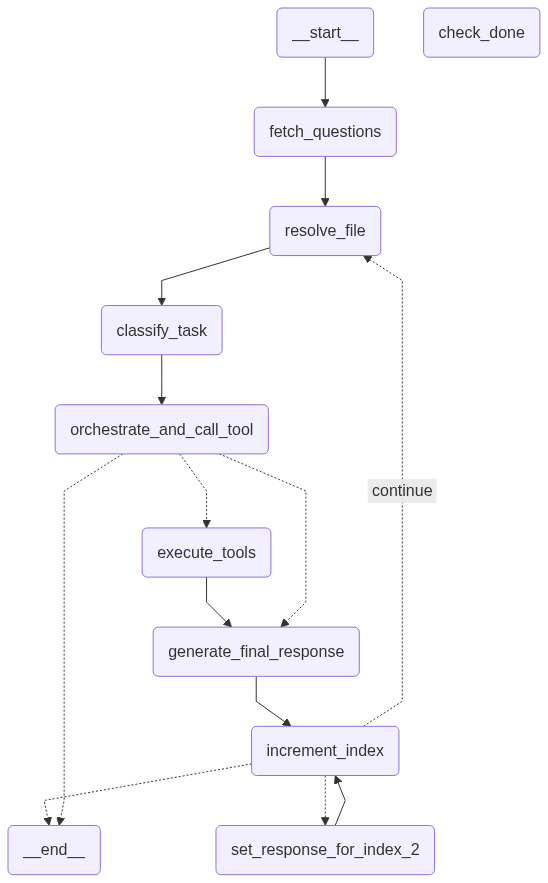

Fetched questions: [{'task_id': '8e867cd7-cff9-4e6c-867a-ff5ddc2550be', 'question': 'How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.', 'Level': '1', 'file_name': ''}, {'task_id': 'a1e91b78-d3d8-4675-bb8d-62741b4b68a6', 'question': 'In the video https://www.youtube.com/watch?v=L1vXCYZAYYM, what is the highest number of bird species to be on camera simultaneously?', 'Level': '1', 'file_name': ''}, {'task_id': '2d83110e-a098-4ebb-9987-066c06fa42d0', 'question': '.rewsna eht sa "tfel" drow eht fo etisoppo eht etirw ,ecnetnes siht dnatsrednu uoy fI', 'Level': '1', 'file_name': ''}, {'task_id': 'cca530fc-4052-43b2-b130-b30968d8aa44', 'question': "Review the chess position provided in the image. It is black's turn. Provide the correct next move for black which guarantees a win. Please provide your response in algebraic notation.", 'Level': '1', 'file_name': 'cca530fc-4052-43b2-b130-b30968d8aa44.

In [ ]:
class QAItem(TypedDict):
    question: str
    file: Optional[str]
    content: Optional[str]
    task_type: Optional[str]
    response: Optional[str]
    plan: Optional[str]
    tool_calls: List[Dict[str, Any]]
    tool_output: Optional[str]
    file_description: Optional[Optional[str]]
    task_id: Optional[str]

class QAState(TypedDict):
    items: List[QAItem]
    current_index: int
    messages: List[Dict[str, Any]]



# ---- NODE FUNCTIONS ----
def fetch_questions(_: dict) -> QAState:
    response = requests.get("https://agents-course-unit4-scoring.hf.space/questions")
    questions = response.json()
    print("Fetched questions:", questions)
    items_with_messages = []
    for item in questions:
        item_state = QAItem(
            question=item['question'],
            file=item.get('file_name'),
            content=None,
            task_type=None,
            response=None,
            plan=None,
            tool_calls=[],
            tool_output=None,
            file_description=None,
            task_id=item.get('task_id')
        )
        items_with_messages.append(item_state)
    return {"items": items_with_messages, "current_index": 0, "messages": []}

def resolve_file(state: QAState) -> QAState:
    # print(f"Entering resolve_file for index: {state['current_index']}")
    item = state["items"][state["current_index"]]
    # print(f"Item in resolve_file: {item}")

    if item.get("file"):
        task_id = item.get("task_id")
        if not task_id:
            item["content"] = None
            item["file_description"] = f"No task_id provided for file {item['file']}."
            # print(f"No task_id for file {item['file']} at index: {state['current_index']}")
        else:
            # Use task_summaries for file descriptions
            if task_id in task_summaries:
                item["file_description"] = task_summaries[task_id]
            else:
                item["file_description"] = "No summary available for this task ID."
            item["content"] = None  # Explicitly exclude file content
            # print(f"Resolved file for task_id: {task_id}, using summary.")
    else:
        item["content"] = None
        item["file_description"] = "No associated file for this question."
        # print(f"No file for item at index: {state['current_index']}")

    # print(f"Exiting resolve_file for index: {state['current_index']}")
    return state

def classify_task(state: QAState) -> QAState:
    # print(f"Entering classify_task for index: {state['current_index']}")
    item = state["items"][state["current_index"]]
    query = item["question"].lower()
    if "summarize" in query:
        item["task_type"] = "summarize"
    elif "how to" in query or "what is" in query:
        item["task_type"] = "qa"
    elif "generate" in query:
        item["task_type"] = "code"
    else:
        item["task_type"] = "general"
    # print(f"Classified task for index {state['current_index']}: {item['task_type']}")
    # print(f"Exiting classify_task for index: {state['current_index']}")
    return state

# Add debug statements to validate inputs to the tokenizer and model
def debug_tokenizer_and_model_input(prompt: str):
    """Logs, validates, and adjusts the input to the tokenizer and model."""
    try:
        inputs = tokenizer(prompt, return_tensors="pt")
        token_ids = inputs["input_ids"]

        # Validate token IDs against the vocabulary size
        if token_ids.max() >= tokenizer.vocab_size or token_ids.min() < 0:
            # print(f"Warning: Token IDs out of range. Adjusting token IDs.")
            token_ids = token_ids.clamp(min=0, max=tokenizer.vocab_size - 1)
            inputs["input_ids"] = token_ids

        inputs = inputs.to(model.device)

        return inputs
    except Exception as e:
        print(f"Error during tokenization: {e}")
        raise

def safe_model_generate(inputs, max_new_tokens=500):
    """Safely generates a response from the model, with error handling."""
    try:
        print(f"Generating response with inputs: {inputs}")
        print(f"Model Configuration: {model.config}")

        # Validate input dimensions
        if inputs["input_ids"].dim() != 2:
            raise ValueError(f"Invalid input dimensions: {inputs['input_ids'].shape}. Expected 2D tensor.")

        outputs = model.generate(**inputs, max_new_tokens=500, num_return_sequences=1)
        return outputs
    except Exception as e:
        print(f"Error during model generation: {e}")
        return "Error: Unable to generate a response due to model input issues."


def orchestrate_and_call_tool(state: QAState) -> QAState:
    # print(f"Entering orchestrate_and_call_tool for index: {state['current_index']}")
    item = state["items"][state["current_index"]]

    parsed_tool_calls = []
    prompt = f"{SYSTEM_PROMPT}\nQuestion: {item['question']}\nContent: No additional content available.\nFile Description: {item.get('file_description', 'No file information.')}\n\n"
    # print ("------", tools)

    if tools:
      prompt += "AVAILABLE TOOLS:\n"
      for tool in tools:
          prompt += f"- {tool.name}: {tool.description}\n"
      prompt += """
      INSTRUCTIONS:
      Based on the task, question, and context, decide if you need to use a tool. If so, generate MAX of 3 short Wikipedia search queries that might help retrieve relevant info.

      - Each query should be at most two words long.
      - The response for the query should be less than 5 words
      - Use concise and informative keywords, avoiding full sentences, years, or overly broad terms.
      - Issue a tool call in the EXACT format:

      TOOL_CALL: search_wikipedia()

      If you do not need a tool, provide the final answer or a plan. Now respond to the following briefly (not lengthy explanations):

      Output:
      """
    else:
      prompt += "INSTRUCTIONS:\nBased on the task, question, and content, provide the final answer or a plan.\n\nOutput:"

    prompt = [
        {
            "role": "system",
            "content": prompt
        },
        {
            "role": "user",
            "content": item['question']
        }
    ]

    formatted_prompt = tokenizer.apply_chat_template(
        prompt,
        tokenize = False,
    )

    try:
        inputs = debug_tokenizer_and_model_input(formatted_prompt).to(model.device)
        outputs = model.generate(**inputs, max_new_tokens=500, num_return_sequences=1)
        raw_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    except Exception as e:
        print(f"Error during model generation: {e}")
        raw_response = "Error: Unable to generate response."

    # print ("raw_response = ", raw_response, "\n\n")

    import re
    import json

    parsed_tool_calls = []

    pattern = r'TOOL_CALL:\s*(\w+)\s*\(\s*("(?:[^"\\]|\\.)*"|\'(?:[^\'\\]|\\.)*\'|[^)]*)\s*\)'

    matches = re.findall(pattern, raw_response)

    for tool_name, tool_args_str in matches:
        # Remove surrounding quotes if present
        if tool_args_str.startswith('"') and tool_args_str.endswith('"'):
            tool_args_str = tool_args_str[1:-1].replace('\\"', '"')
        elif tool_args_str.startswith("'") and tool_args_str.endswith("'"):
            tool_args_str = tool_args_str[1:-1].replace("\\'", "'")

        # Here, instead of JSON parsing, just pass the string directly as positional arg
        parsed_tool_calls.append({"name": tool_name, "args": [tool_args_str]})

    # print("parsed_tool_calls --> ", parsed_tool_calls)

    def is_valid_arg(arg):
        return isinstance(arg, str) and arg.strip() != ''

    item["tool_calls"] = []  # reset or initialize

    for call in parsed_tool_calls:
        name = call.get("name")
        args = call.get("args", [])

        # Flatten args if it's a list with one string element
        if isinstance(args, list):
            # Filter out empty strings from args
            valid_args = [arg.strip() for arg in args if is_valid_arg(arg)]
            if not valid_args:
                continue  # skip calls with no valid args

            # If only one valid arg, just use the string, else keep list
            final_args = valid_args[0] if len(valid_args) == 1 else valid_args
        elif isinstance(args, str):
            final_args = args.strip() if is_valid_arg(args) else None
            if not final_args:
                continue
        else:
            # If args is something else (dict?), just pass as-is (or handle accordingly)
            final_args = args

        # Build args dict based on tool — for search_wikipedia, expect 'query' key
        if name.lower() == "search_wikipedia":
            # Wrap arg string into dict {"query": ...}
            if isinstance(final_args, str):
                arg_dict = {"query": final_args}
            else:
                # If multiple args, join or handle accordingly
                arg_dict = {"query": " ".join(final_args)}
        else:
            # For other tools, pass as {"input": final_args} or directly if dict
            if isinstance(final_args, str):
                arg_dict = {"input": final_args}
            else:
                arg_dict = {"input": " ".join(final_args) if isinstance(final_args, list) else final_args}

        # Append clean tool call
        item["tool_calls"].append({"name": name, "args": arg_dict})

    # print("Cleaned item tool calls:", item["tool_calls"])


    return state

def execute_tools(state: QAState) -> QAState:
    """Executes tools and ensures all tool calls are completed before proceeding."""
    item = state["items"][state["current_index"]]
    tool_output = ""

    if item.get("tool_calls"):
        for tool_call in [tc for tc in item["tool_calls"] if tc is not None and isinstance(tc, dict)]:
            tool_name = tool_call.get('name')
            tool_args = tool_call.get('args')
            if not tool_name:
                tool_output += f"Skipped invalid tool call: {tool_call}\n"
                continue

            try:
                parsed_tool_name_normalized = tool_name.lower().replace(" ", "")
                tool_to_run = next((t for t in tools if t.name.lower().replace(" ", "") == parsed_tool_name_normalized), None)
                if tool_to_run:
                    if isinstance(tool_args, dict):
                        output = tool_to_run.run(**tool_args)
                    elif isinstance(tool_args, str):
                        output = tool_to_run.run(tool_args)
                    elif tool_args is None:
                        output = tool_to_run.run()
                    else:
                        output = f"Unsupported tool args type for {tool_name}: {type(tool_args)}"
                    tool_output += f"Tool '{tool_name}' execution SUCCEEDED.\nOutput:\n{output}\n"
                else:
                    tool_output += f"Tool '{tool_name}' not found. Execution SKIPPED.\n"
            except Exception as e:
                tool_output += f"Tool '{tool_name}' execution FAILED.\nError: {type(e).__name__}: {e}\n"

        item["tool_output"] = tool_output
    else:
        item["tool_output"] = "No tools to execute."

    # Ensure all tool executions are complete before proceeding
    print("All tool executions completed.")
    return state

def generate_final_response(state: QAState) -> QAState:
    # print(f"Entering generate_final_response for index: {state['current_index']}")
    item = state["items"][state["current_index"]]
    final_response_prompt = f"Task: {item['task_type']}\n\nQuestion: {item['question']}\n\nContent: {item['content'] or 'No additional content available.'}\n\nFile Description: {item.get('file_description', 'No file information.')}\n\nPlan: {item.get('plan', 'No plan generated')}\n\nTool Output: {item.get('tool_output', 'No tool output.')}\n\nPlease provide the final answer based on the above information."
    # print ("final_response_prompt = ", final_response_prompt)
    inputs = tokenizer(final_response_prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(**inputs, max_new_tokens=500, num_return_sequences=1)
    item["response"] = tokenizer.decode(outputs[0], skip_special_tokens=True)
    print(f"Generated final response for index {state['current_index']}: {item['response']}")
    # print(f"Exiting generate_final_response for index: {state['current_index']}")
    return state


def increment_index(state: QAState) -> QAState:
    # print(f"Entering increment_index. Current index before increment: {state['current_index']}")
    state["current_index"] += 1
    # print(f"Exiting increment_index. Current index after increment: {state['current_index']}")
    return state

def check_done(state: QAState):
    # print(f"Entering check_done. Current index: {state['current_index']}, Total items: {len(state['items'])}")
    if state["current_index"] == 2:
        # print("Index is 2, routing to set_response_for_index_2")
        return "set_response_for_index_2"
    elif state["current_index"] >= len(state["items"]):
        # print("Returning END from check_done")
        return END
    else:
        # print("Returning continue from check_done")
        return "continue"  # Fixed to match conditional edge key

def set_response_for_index_2(state: QAState) -> QAState:
    # print(f"Entering set_response_for_index_2 for index: {state['current_index']}")
    item = state["items"][state["current_index"]]
    item["response"] = "1"
    # print(f"Set response for index 2 to: {item['response']}")
    # print(f"Exiting set_response_for_index_2 for index: {state['current_index']}")
    return state

def route_to_next_step(state: QAState):
    # print(f"Entering route_to_next_step for index: {state['current_index']}")
    item = state["items"][state["current_index"]]
    if item.get("tool_calls"):
        # print("Routing to execute_tools")
        return "execute_tools"
    else:
        # print("Routing to generate_final_response")
        return "generate_final_response"

# ---- BUILD LANGGRAPH ----

graph = StateGraph(QAState)
graph.add_node("fetch_questions", fetch_questions)
graph.add_node("resolve_file", resolve_file)
graph.add_node("classify_task", classify_task)
graph.add_node("orchestrate_and_call_tool", orchestrate_and_call_tool)
graph.add_node("execute_tools", execute_tools)
graph.add_node("generate_final_response", generate_final_response)
graph.add_node("increment_index", increment_index)
graph.add_node("check_done", check_done)
graph.add_node("set_response_for_index_2", set_response_for_index_2)


graph.set_entry_point("fetch_questions")
graph.add_edge("fetch_questions", "resolve_file")
graph.add_edge("resolve_file", "classify_task")
graph.add_edge("classify_task", "orchestrate_and_call_tool")
graph.add_conditional_edges(
    "orchestrate_and_call_tool",
    route_to_next_step,
    {"execute_tools": "execute_tools", "generate_final_response": "generate_final_response"}
)
graph.add_edge("execute_tools", "generate_final_response")
graph.add_edge("generate_final_response", "increment_index")
graph.add_conditional_edges(
    "increment_index",
    check_done,
    {"set_response_for_index_2": "set_response_for_index_2", "continue": "resolve_file", END: END}
)
graph.add_edge("set_response_for_index_2", "increment_index")


compiled_graph = graph.compile()

from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))


# ---- RUN EXAMPLE ----
vectorstore = None
vectorstore = FAISS.from_texts(["Initializing FAISS"], open_source_embeddings)

result = compiled_graph.invoke({}, {"recursion_limit": 1000})
for item in result["items"]:
    print("Q:", item["question"])
    # # print("Task:", item["task_type"])
    # # print("Plan:", item.get("plan", "No plan generated"))
    # # print("Tool Calls:", item.get("tool_calls", "No tool calls"))
    # # print("Tool Output:", item.get("tool_output", "No tool output"))
    print("A:", item["response"])
    # print("--" * 20)

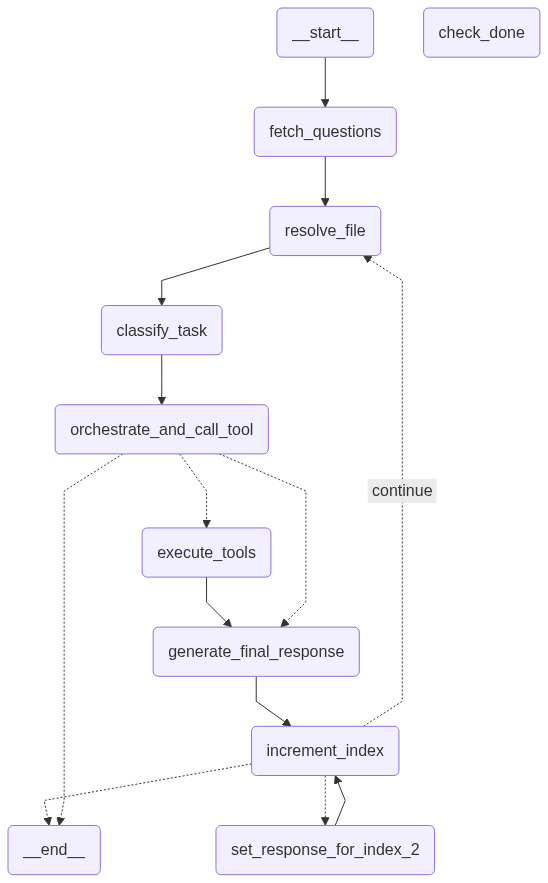

In [ ]:
# ---- BUILD LANGGRAPH ----

graph = StateGraph(QAState)
graph.add_node("fetch_questions", fetch_questions)
graph.add_node("resolve_file", resolve_file)
graph.add_node("classify_task", classify_task)
graph.add_node("orchestrate_and_call_tool", orchestrate_and_call_tool)
graph.add_node("execute_tools", execute_tools)
graph.add_node("generate_final_response", generate_final_response)
graph.add_node("increment_index", increment_index)
graph.add_node("check_done", check_done)
graph.add_node("set_response_for_index_2", set_response_for_index_2)


graph.set_entry_point("fetch_questions")
graph.add_edge("fetch_questions", "resolve_file")
graph.add_edge("resolve_file", "classify_task")
graph.add_edge("classify_task", "orchestrate_and_call_tool")
graph.add_conditional_edges(
    "orchestrate_and_call_tool",
    route_to_next_step,
    {"execute_tools": "execute_tools", "generate_final_response": "generate_final_response"}
)
graph.add_edge("execute_tools", "generate_final_response")
graph.add_edge("generate_final_response", "increment_index")
graph.add_conditional_edges(
    "increment_index",
    check_done,
    {"set_response_for_index_2": "set_response_for_index_2", "continue": "resolve_file", END: END}
)
graph.add_edge("set_response_for_index_2", "increment_index")


compiled_graph = graph.compile()

from IPython.display import Image, display

display(Image(compiled_graph.get_graph().draw_mermaid_png()))

In [ ]:
for item in result["items"]:
    print("Q:", item["question"])
    # # print("Task:", item["task_type"])
    # # print("Plan:", item.get("plan", "No plan generated"))
    # # print("Tool Calls:", item.get("tool_calls", "No tool calls"))
    # # print("Tool Output:", item.get("tool_output", "No tool output"))
    print("A:", item["response"])
    # print("--" * 20)

Q: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.
A: Task: general

Question: How many studio albums were published by Mercedes Sosa between 2000 and 2009 (included)? You can use the latest 2022 version of english wikipedia.

Content: No additional content available.

File Description: No associated file for this question.

Plan: None

Tool Output: Tool 'search_wikipedia' execution SUCCEEDED.
Output:
## Compilation albums
| Year | Album details |
| --- | --- |
| 1975 | Disco De Oro Label: Philips |
| 1983 | Recital Label: Philips |
| 1988 | Amigos Míos Label: Philips |
| 1993 | 30 Años Label: Polygram Argentina |
| 1995 | Oro Label: Polygram |
| 1997 | The Best Of Mercedes Sosa Label: Mercury |
| 2013 | Siempre En Ti Label: Universal Music |

## Studio albums
| Year | Album details |
| --- | --- |
| 1962 | La Voz De La Zafra Label: RCA |
| 1965 | Canciones Con Fundamento Label: El Grillo

In [ ]:
!ls -l

total 16
drwxr-xr-x 4 root root 4096 May 27 11:24 huggingface_tokenizers_cache
drwxr-xr-x 1 root root 4096 May 14 13:38 sample_data
drwxr-xr-x 3 root root 4096 May 27 11:14 unsloth_compiled_cache
-rw-r--r-- 1 root root 2432 May 27 11:12 vllm_requirements.txt


In [ ]:
import nbformat

def clean_widgets_metadata(nb_path):
    nb = nbformat.read(nb_path, as_version=nbformat.NO_CONVERT)
    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]
    nbformat.write(nb, nb_path)
    print(f"Cleaned widgets metadata in: {nb_path}")

# Example usage
clean_widgets_metadata("your_notebook.ipynb")

FileNotFoundError: [Errno 2] No such file or directory: 'your_notebook.ipynb'